<h1>Import Library</h1>

In [1]:
import re
import pandas as pd
import numpy as np
import nltk
import json
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
from nltk.tokenize import RegexpTokenizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split

<h1>Baca Data</h1>

In [2]:
df = pd.read_csv("label_manual.csv")
label_col = "label"
total_data = len(df)
labeled = df[label_col].notna().sum()
unlabeled = df[label_col].isna().sum()
label_counts = df[label_col].value_counts()

print("===== Statistik Labeling =====")
print(f"Total data        : {total_data}")
print(f"Sudah dilabeli    : {labeled}")
print(f"Belum dilabeli    : {unlabeled}")
print("\n--- Total per label ---")
print(label_counts)

===== Statistik Labeling =====
Total data        : 1221
Sudah dilabeli    : 250
Belum dilabeli    : 971

--- Total per label ---
label
positive    100
negative    100
neutral      50
Name: count, dtype: int64


In [3]:
texts = df["full_text"].astype(str)

In [4]:
topic_keywords = [
    "menkeu", "purbaya", "sri mulyani", "menteri keuangan", "ekonomi",
    "fiskal", "pemerintah", "apbn", "inflasi", "defisit", "utang negara"
]

irrelevant_keywords = [
    "download", "promo", "iklan", "klik link", "aplikasi", "follow", 
    "giveaway", "voucher", "diskon", "gratis", "registrasi", "daftar", "event"
]


def is_relevant(text):
    text_lower = text.lower()
    if any(bad in text_lower for bad in irrelevant_keywords):
        return False
    return any(topic in text_lower for topic in topic_keywords)

mask = df["full_text"].astype(str).apply(is_relevant)
df = df[mask].reset_index(drop=True)

texts = df["full_text"].astype(str)

print(f"Jumlah data setelah pembersihan topik: {len(df)} baris tersisa.")

Jumlah data setelah pembersihan topik: 1221 baris tersisa.


<h1>PraPemrosesan import Stemmer dari Sastrawi</h1>

In [5]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_nltk = set(stopwords.words('indonesian'))
stop_sastrawi = set(StopWordRemoverFactory().get_stop_words())
stop_words = stop_nltk.union(stop_sastrawi)

tokenizer = RegexpTokenizer(r'\w+')

<h1>Pembersihan data menggunakan case folding CPMK 2</h1>

In [6]:
def case_folding(text):
    text = text.lower()
    return text

In [7]:
singkatan_map = {
    "gk": "tidak", "ga": "tidak", "gak": "tidak", "nggak": "tidak", "ngga": "tidak",
    "tdk": "tidak", "tak": "tidak", "t": "tidak", "ndak": "tidak", "enggak": "tidak",
    "yg": "yang", "dgn": "dengan", "dg": "dengan", "krn": "karena", "karen": "karena",
    "utk": "untuk", "biar": "agar", "spy": "supaya", "tp": "tapi", "pdhl": "padahal",
    "sdh": "sudah", "udh": "sudah", "udah": "sudah", "dah": "sudah", "blm": "belum",
    "td": "tidak", "jd": "jadi", "jg": "juga", "dll": "", "dst": "", "dsb": "",
    "gw": "saya", "gue": "saya", "gua": "saya", "sy": "saya", "aq": "saya", "aqh": "saya",
    "aku": "saya", "aqo": "saya", "ane": "saya", "admin": "saya",
    "km": "kamu", "kmu": "kamu", "klo": "kalau", "klu": "kalau", "kalo": "kalau",
    "loe": "kamu", "lu": "kamu", "lo": "kamu", "ente": "kamu", "dirimu": "kamu",
    "dy": "dia", "dya": "dia", "doi": "dia", "dya": "dia", "mrk": "mereka", "tmn": "teman",
    "bgt": "banget", "bgd": "banget", "bnget": "banget", "bngt": "banget", "parahh": "parah",
    "bener": "benar", "bner": "benar", "bneran": "benar", "sumpahh": "sumpah",
    "seriusss": "serius", "seriusan": "serius", "mantul": "mantap betul",
    "btul": "betul", "btl": "betul", "mantep": "mantap", "mantepp": "mantap",
    "skrg": "sekarang", "skr": "sekarang", "td": "tadi", "tadii": "tadi",
    "besok": "besok", "bsok": "besok", "nnti": "nanti", "ntar": "nanti", "lusa": "lusa",
    "dlu": "dulu", "dl": "dulu", "duluu": "dulu", "kmrn": "kemarin", "kmren": "kemarin",
    "trus": "terus", "trs": "terus", "lanjuttt": "lanjut",
    "dr": "dari", "drpd": "daripada", "dpn": "depan", "blkg": "belakang", "sblh": "sebelah",
    "tmpt": "tempat", "rmh": "rumah", "kantor": "kantor", "kntor": "kantor", "sklh": "sekolah",
    "kls": "kelas", "jl": "jalan", "jln": "jalan", "rp": "rupiah", "juta": "juta", "jt": "juta",
    "miliar": "miliar", "milyar": "miliar", "m": "miliar", "t": "triliun", "triliun": "triliun",
    "kmh": "kamar", "kmr": "kamar",
    "wkwk": "", "wk": "", "wkwkwk": "", "haha": "", "hehe": "", "hihi": "", "hoho": "",
    "ckck": "", "btw": "", "lol": "", "xixixi": "", "huhu": "", "ampun": "", "yah": "", "ya": "",
    "lho": "", "loh": "", "dong": "", "deh": "", "sih": "", "lah": "", "nih": "", "tuh": "",
    "kan": "", "kok": "", "cih": "", "astaga": "", "anjir": "", "anjay": "", "anj": "",
    "pls": "tolong", "tolonglah": "tolong", "pliss": "tolong", "plz": "tolong",
    "thx": "terima kasih", "tq": "terima kasih", "makasih": "terima kasih", "mksih": "terima kasih",
    "mksh": "terima kasih", "mks": "terima kasih", "terimakasih": "terima kasih",
    "thanks": "terima kasih", "suwun": "terima kasih",
    "pagi": "selamat pagi", "mlm": "malam", "malem": "malam", "sore": "sore", "siang": "siang",
    "dm": "pesan pribadi", "pm": "pesan pribadi", "fb": "facebook", "ig": "instagram",
    "yt": "youtube", "vid": "video", "vidio": "video", "acc": "akun", "akunmu": "akun kamu",
    "id": "identitas", "link": "tautan", "app": "aplikasi", "web": "situs", "wa": "whatsapp",
    "bbrp": "beberapa", "brp": "berapa", "sm": "sama", "sma": "sama", "ama": "sama",
    "kl": "kalau", "bljr": "belajar", "bljar": "belajar", "sklh": "sekolah",
    "mnt": "menit", "mggu": "minggu", "thn": "tahun", "bln": "bulan",
    "org": "orang", "mslh": "masalah", "krj": "kerja", "pkrjaan": "pekerjaan",
    "prtanyaan": "pertanyaan", "jwbn": "jawaban", "bales": "balas",
    "knp": "kenapa", "kenp": "kenapa", "gmn": "bagaimana", "gmna": "bagaimana", "gimana": "bagaimana",
    "bisaaa": "bisa", "gpp": "tidak apa apa", "gapapa": "tidak apa apa", "gapa": "tidak apa apa",
    "kt": "kota", "da": "daerah", "tmp": "tempat", "trm": "terima", "tkp": "tempat kejadian perkara",
    "jl": "jalan", "jln": "jalan", "rt": "rukun tetangga", "rw": "rukun warga",
    "bucin": "budak cinta", "gabut": "tidak ada kegiatan", "mager": "malas gerak", "ri":"republik indonesia",
    "baper": "bawa perasaan", "ngab": "abang", "bang": "abang", "sis": "kakak",
    "bro": "kakak", "bestie": "teman", "besties": "teman", "crush": "gebetan",
    "gebetan": "orang disukai", "pdkt": "pendekatan", "nembak": "menyatakan cinta",
    "ghosting": "menghilang tiba tiba", "mantan": "bekas pacar", "kg": "kilogram", "cht":"chat",
    "ok": "baik", "oke": "baik", "okey": "baik", "sip": "baik", "siip": "baik", "okayy": "baik"
}


<h1>Preprocessing regex, tokenisasi dan pemakaian stemmer CPMK 3</h1>

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b(menkeu|purbaya)\b', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'http\S+|www\S+', ' ', text)     
    text = re.sub(r'@\w+', ' ', text)                
    text = emoji.demojize(text)                      
    text = re.sub(r'\d+', ' ', text)                 
    text = re.sub(r'[^\w\s]', ' ', text)             
    text = re.sub(r'(.)\1{2,}', r'\1', text)         
    text = re.sub(r'\s+', ' ', text).strip()         

    tokens = tokenizer.tokenize(text)

    tokens = [singkatan_map.get(w, w) for w in tokens if w not in singkatan_map or singkatan_map[w] != ""]

    tokens = [w for w in tokens if w not in stop_words]

    tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)

df["preprocessing"] = texts.apply(clean_text)


In [9]:
df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding CPMK2": texts.apply(case_folding),
    "preprocessing CPMK3": df["preprocessing"]
})

<h1>CPMK4 N-Gram</h1>

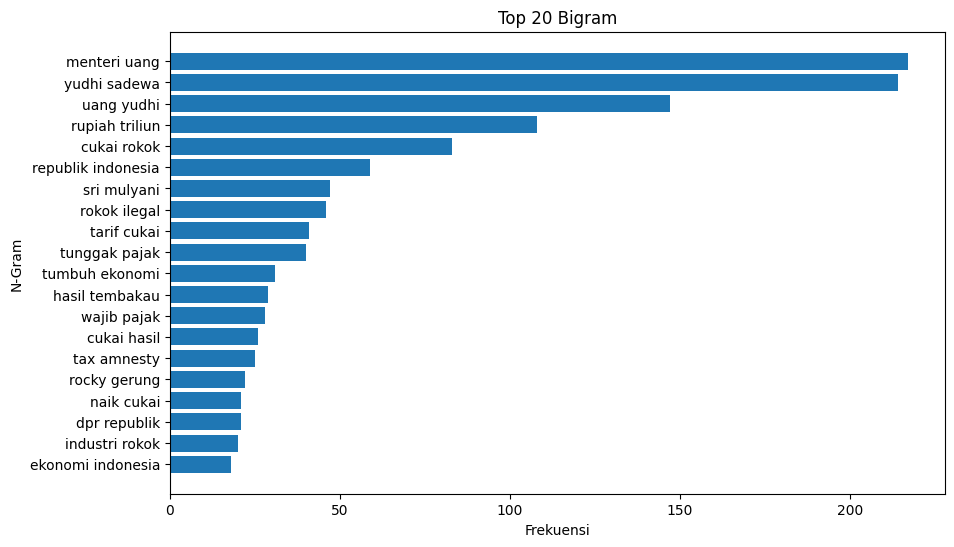

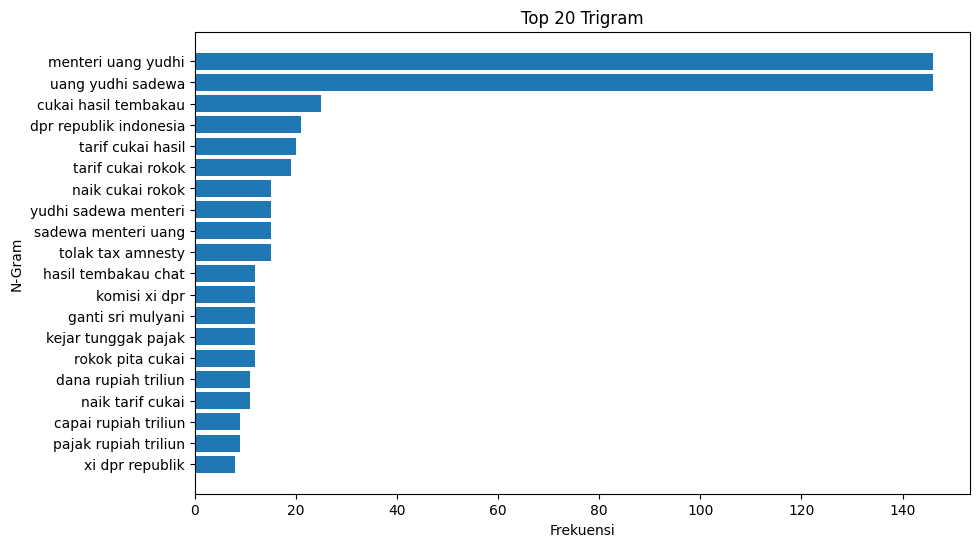

In [10]:
corpus = df_new["preprocessing CPMK3"].astype(str)

def plot_top_ngrams(corpus, ngram_range=(2, 2), top_n=20, title="Top N-Grams"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    ngram_df = pd.DataFrame(words_freq, columns=['NGram', 'Count'])

    plt.figure(figsize=(10,6))
    plt.barh(ngram_df['NGram'][::-1], ngram_df['Count'][::-1])
    plt.title(title)
    plt.xlabel("Frekuensi")
    plt.ylabel("N-Gram")
    plt.show()

plot_top_ngrams(corpus, ngram_range=(2, 2), title="Top 20 Bigram")
plot_top_ngrams(corpus, ngram_range=(3, 3), title="Top 20 Trigram")


<h1>CPMK4 WordCloud</h1>

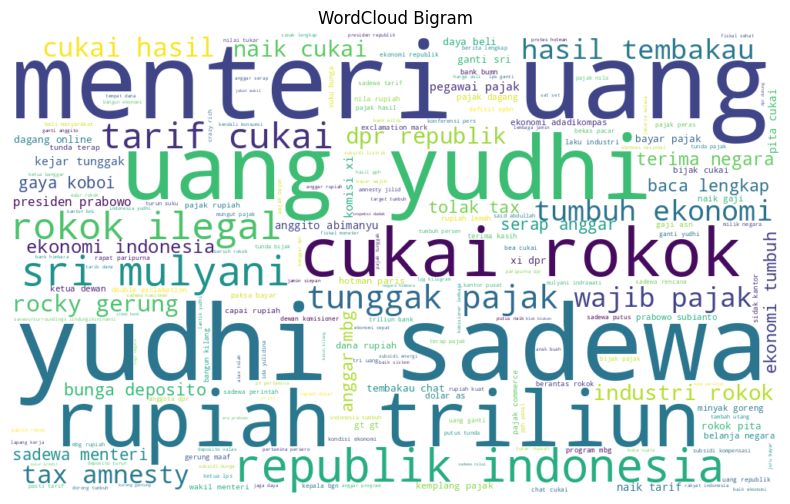

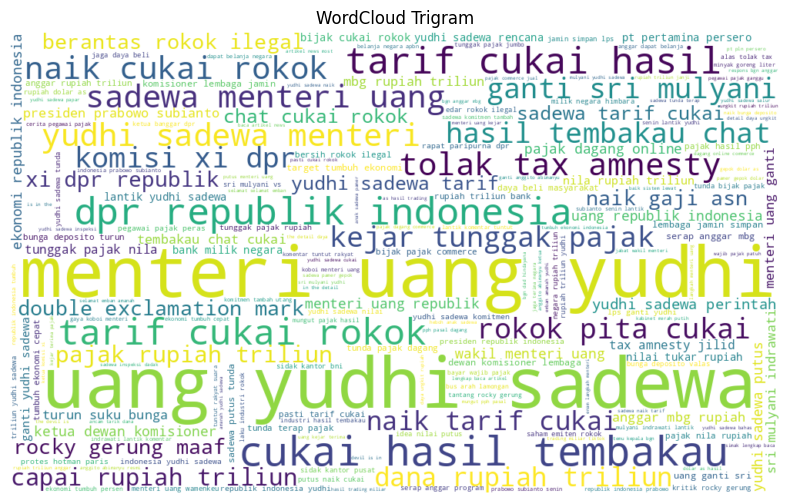

In [11]:
def generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    freq_dict = dict(words_freq)
    
    plt.figure(figsize=(10,6))
    wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram")
generate_ngram_wordcloud(corpus, ngram_range=(3,3), title="WordCloud Trigram")


<h1>Pelabelan Self-Training
</h1>

In [22]:
labeled_df = df[df["label"].notna()]
unlabeled_df = df[df["label"].isna()]
print("Total labeled:", len(labeled_df))
print("Total unlabeled:", len(unlabeled_df))

Total labeled: 250
Total unlabeled: 971


In [13]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_labeled = vectorizer.fit_transform(labeled_df["preprocessing"].astype(str))
y_labeled = labeled_df["label"].astype(str)

X_unlabeled = vectorizer.transform(unlabeled_df["preprocessing"].astype(str))


In [14]:
base_clf = LogisticRegression(max_iter=500)

self_training_model = SelfTrainingClassifier(
    base_clf,
    threshold=0.95,
    verbose=True
)

In [15]:
X_all = np.vstack([X_labeled.toarray(), X_unlabeled.toarray()])

y_all = pd.concat([
    y_labeled,
    pd.Series([-1] * len(unlabeled_df))
], ignore_index=True)

self_training_model.fit(X_all, y_all)

SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=500),
                       threshold=0.95, verbose=True)

In [16]:
pseudo_labels = self_training_model.predict(X_unlabeled)
pseudo_probs = self_training_model.predict_proba(X_unlabeled).max(axis=1)

unlabeled_df["pseudo_label"] = pseudo_labels
unlabeled_df["confidence"] = pseudo_probs

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1792\3474361691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df["pseudo_label"] = pseudo_labels
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1792\3474361691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df["confidence"] = pseudo_probs


In [17]:
final_df = pd.concat([
    labeled_df.rename(columns={"label": "final_label"}),
    unlabeled_df.rename(columns={"pseudo_label": "final_label"})
], ignore_index=True)

final_df.to_csv("label_self_training.csv", index=False)

print("\n=== LABEL DISTRIBUTION AFTER SELF TRAINING ===")
print(final_df["final_label"].value_counts())


=== LABEL DISTRIBUTION AFTER SELF TRAINING ===
final_label
negative    608
positive    501
neutral     112
Name: count, dtype: int64


<h1>Visualisasi</h1>

In [18]:
df_label = pd.read_csv("label_self_training.csv")

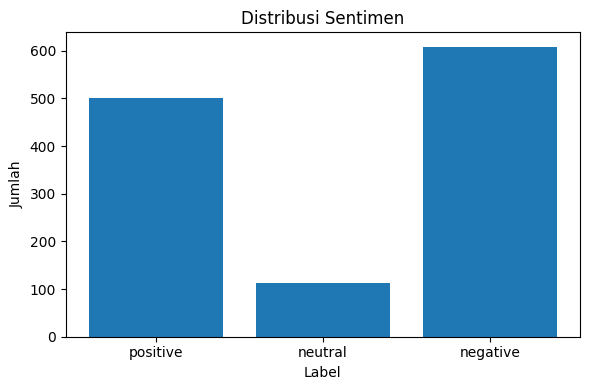

In [19]:
label_counts = df_label["final_label"].value_counts()
order = ["positive", "neutral", "negative"]

counts_ordered = [label_counts.get(lbl, 0) for lbl in order]

plt.figure(figsize=(6,4))
plt.bar(order, counts_ordered)
plt.title("Distribusi Sentimen")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()